In [44]:
import secrets, base64, qrcode, time, struct, hmac, hashlib


## Step 1: Generate a Secret Key

In [45]:

secret = secrets.token_bytes(20)
base32 = base64.b32encode(secret).decode("utf-8").replace("=","")
base32_secret =  base32


## Step 2: Generate the QR Code URL for Client Onboarding

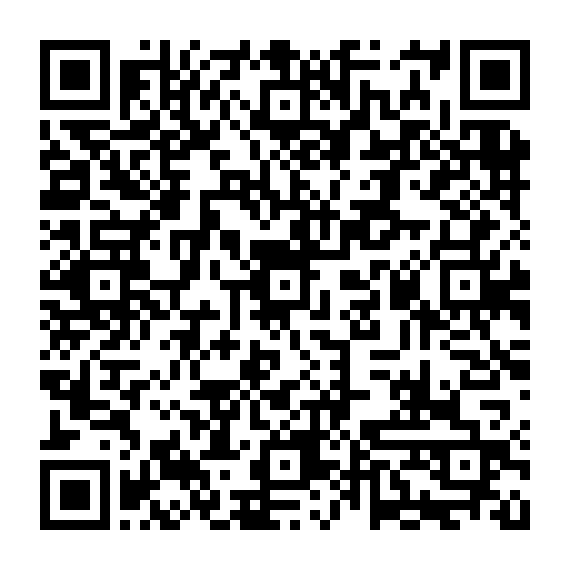

In [46]:
issuer = "Aneesh Patne"
account = "aneesh@example.com"
URI = f"otpauth://totp/{issuer}:{account}?secret={base32_secret}&issuer={issuer}&algorithm=SHA1&digits=6&period=30"
qrcode.make(URI)


# Step 3: Generating a counter and Packing the counter into an 8-byte big-endian array

In [47]:
now = int(time.time())
t0, period = 0, 30
counter = int((now - t0) / period)
counter_bytes = struct.pack(">Q", counter)
counter_bytes

b'\x00\x00\x00\x00\x03}\xf2\xbc'

# Step 4 : Compute the HMAC digest

In [48]:
key = base64.b32decode(base32_secret.upper().replace(' ', ''), casefold=True)

In [52]:
mac = hmac.new(key, counter_bytes, hashlib.sha1).digest()
mac

b'\x9a\xa6\x0b\xd9U\xb1\x10g?M\xa4\xcd\x91\xdd\xf8\x92\xeca\xb1\x8b'

Step 5: Generate the OTP

In [62]:
# last 4 bits
offset = mac[-1] & 0x0F
# Dynamic Binary Code
dbc = mac[offset:offset+4] 
# shave off the most significant 1
code_int = int.from_bytes(dbc, 'big') & 0x7FFFFFFF


In [65]:
digits = 6
otp = code_int % (10 ** digits)
otp

405176